In [2]:
from pyhive import hive
import plotly.graph_objects as go
import plotly.express as px
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import squarify

O código está utilizando túnel SSH por motivos de segurança
O comando para criar o túnel SSH é ssh -v -N -L 10000:localhost:10000 SEU_USUÁRIOs@IP_DO_CLUSTER


### Saldo de contratações vs demissões enfermeiros

In [2]:
conn = hive.Connection(host='localhost', port=10000, username='marcelo_borges', database='curso_hadoop')
cursor = conn.cursor()

In [3]:
query = (
    """SELECT 
        SUBSTR(competenciamov, 1, 4) AS Ano,
        SUM(CASE WHEN saldomovimentacao = 1 THEN 1 ELSE 0 END) AS Total_Contratados,
        SUM(CASE WHEN saldomovimentacao = -1 THEN 1 ELSE 0 END) AS Total_Demitidos,
        SUM(saldomovimentacao) AS Saldo_Anual
    FROM curso_hadoop.caged
    WHERE 
        cbo2002ocupacao IN (
            '223505', '223510', '223515', '223520', '223525', '223530', 
            '223535', '223540', '223545', '223550', '223555', '223560', '223565'
        )
        AND municipio = 520870 
    GROUP BY 
        SUBSTR(competenciamov, 1, 4)
    ORDER BY 
        Ano"""
)

In [4]:
cursor.execute(query)

In [10]:
df_saldo = pd.DataFrame(cursor.fetchall(), columns=[desc[0] for desc in cursor.description])

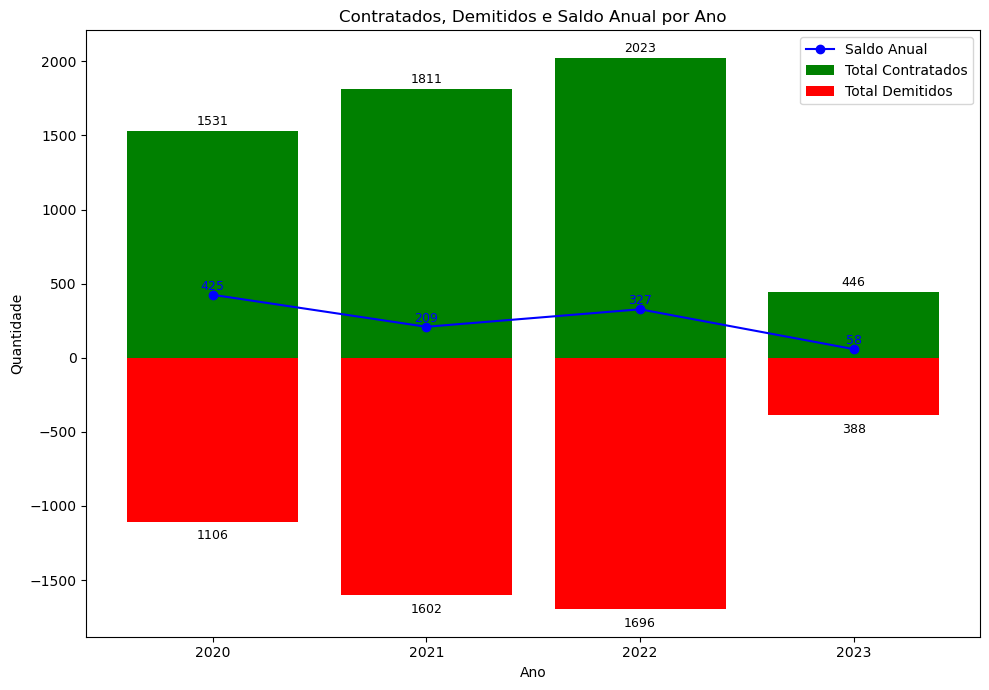

In [27]:
plt.figure(figsize=(10, 7))
bars_contratados = plt.bar(df_saldo['ano'], df_saldo['total_contratados'], label='Total Contratados', color='green')
bars_demitidos = plt.bar(df_saldo['ano'], -df_saldo['total_demitidos'], label='Total Demitidos', color='red')
for bar in bars_contratados:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 20, int(yval), ha='center', va='bottom', fontsize=9)

for bar in bars_demitidos:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval - 50, int(-yval), ha='center', va='top', fontsize=9)

line, = plt.plot(df_saldo['ano'], df_saldo['saldo_anual'], color='blue', marker='o', label='Saldo Anual')

for i, txt in enumerate(df_saldo['saldo_anual']):
    plt.text(df_saldo['ano'][i], df_saldo['saldo_anual'][i] + 15, int(txt), ha='center', va='bottom', fontsize=9, color='blue')

plt.xlabel('Ano')
plt.ylabel('Quantidade')
plt.title('Contratados, Demitidos e Saldo Anual por Ano')
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.savefig('./images/graphs/saldo.png')
plt.show()

In [4]:
conn = hive.Connection(host='localhost', port=10000, username='marcelo_borges', database='curso_hadoop')
cursor = conn.cursor()

In [5]:
query = (
    """SELECT 
        CASE 
            WHEN idade BETWEEN 18 AND 25 THEN '18-25'
            WHEN idade BETWEEN 26 AND 35 THEN '26-35'
            WHEN idade BETWEEN 36 AND 45 THEN '36-45'
            WHEN idade BETWEEN 46 AND 55 THEN '46-55'
            WHEN idade BETWEEN 56 AND 65 THEN '56-65'
            ELSE '65+'
        END AS Faixa_Etaria,
        COUNT(*) AS Contratacoes
    FROM 
        curso_hadoop.caged
    WHERE 
        cbo2002ocupacao IN ('223505', '223510', '223515', '223520', '223525', '223530', '223535', '223540', '223545', '223550', '223555', '223560', '223565')
        AND municipio = 520870 -- código de Goiânia
        AND saldomovimentacao = 1 -- apenas contratações
        AND SUBSTR(competenciamov, 1, 4) = '2023'
    GROUP BY 
        CASE 
            WHEN idade BETWEEN 18 AND 25 THEN '18-25'
            WHEN idade BETWEEN 26 AND 35 THEN '26-35'
            WHEN idade BETWEEN 36 AND 45 THEN '36-45'
            WHEN idade BETWEEN 46 AND 55 THEN '46-55'
            WHEN idade BETWEEN 56 AND 65 THEN '56-65'
            ELSE '65+'
        END
    ORDER BY 
        Faixa_Etaria
    """
)

In [6]:
cursor.execute(query)

In [7]:
df_fx_etaria = pd.DataFrame(cursor.fetchall(), columns=[desc[0] for desc in cursor.description])

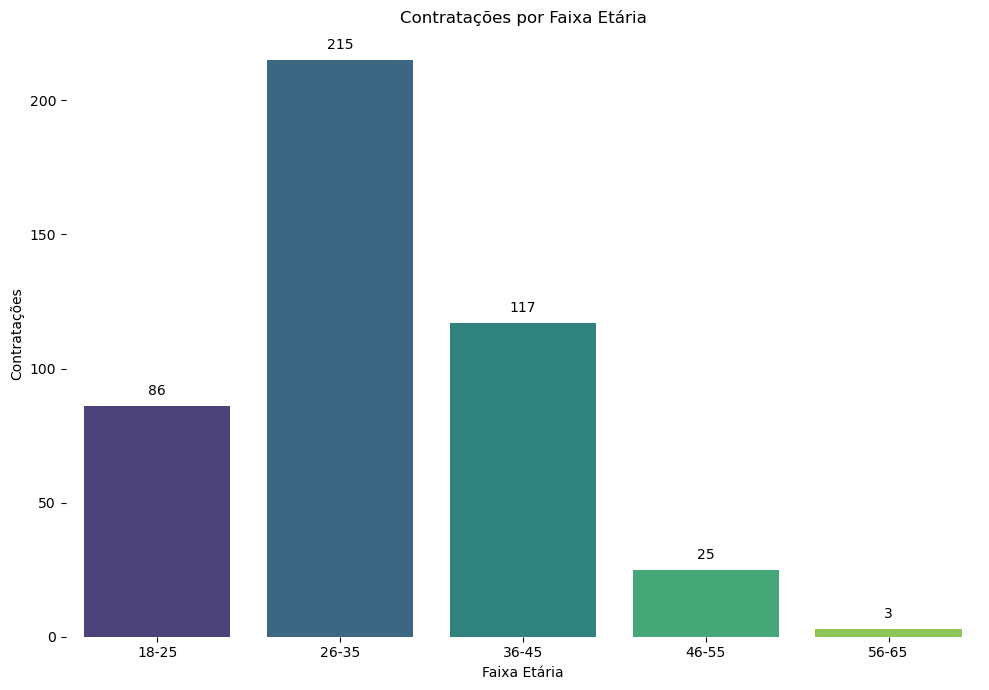

In [8]:
plt.figure(figsize=(10, 7))
bars = sns.barplot(x=df_fx_etaria['faixa_etaria'], y=df_fx_etaria['contratacoes'], palette='viridis')
plt.grid(False)
sns.despine(left=True, bottom=True, right=True, top=True)
for bar in bars.patches:
    yval = bar.get_height()
    bars.text(bar.get_x() + bar.get_width()/2, yval + 3, int(yval), ha='center', va='bottom', fontsize=10, color='black')
plt.xlabel('Faixa Etária')
plt.ylabel('Contratações')
plt.title('Contratações por Faixa Etária')
plt.tight_layout()
plt.savefig('./images/graphs/fx_etaria.png')
plt.show()

In [48]:
conn = hive.Connection(host='localhost', port=10000, username='marcelo_borges', database='curso_hadoop')
cursor = conn.cursor()

In [49]:
query = (
    """
    SELECT 
        s.descricao as Genero,
        COUNT(*) AS Quantidade
    FROM 
        curso_hadoop.caged a,
        curso_hadoop.sexo s 
    WHERE
        a.sexo = s.codigo
        AND cbo2002ocupacao IN ('223505', '223510', '223515', '223520', '223525', '223530', '223535', '223540', '223545', '223550', '223555', '223560', '223565')
        AND municipio = '520870' -- código de Goiânia
        AND saldomovimentacao = 1
        AND SUBSTR(a.competenciamov, 1, 4) = '2023'
    GROUP BY 
        s.descricao
    ORDER BY
        Genero
    """
)

In [50]:
cursor.execute(query)

In [51]:
df_gender = pd.DataFrame(cursor.fetchall(), columns=[desc[0] for desc in cursor.description])

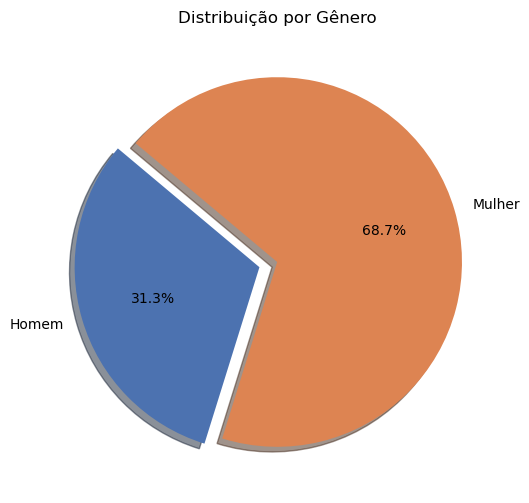

In [54]:
# Recriando o dataframe df_gender
df_gender = pd.DataFrame({
    'genero': ['Homem', 'Mulher'],
    'quantidade': [108, 237]
})

# Definindo as cores e rótulos
colors = ['#4C72B0', '#DD8452']
labels = df_gender['genero']
sizes = df_gender['quantidade']
explode = (0.1, 0)  # explode 1st slice for emphasis

# Criando o gráfico de pizza
plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, shadow=True)
plt.title('Distribuição por Gênero')
plt.savefig('./images/graphs/gender.png')
plt.show()


In [58]:
conn = hive.Connection(host='localhost', port=10000, username='marcelo_borges', database='curso_hadoop')
cursor = conn.cursor()

In [59]:
query = (
    """
        SELECT 
            b.descricao,
            COUNT(*) AS Numero_Contratados
        FROM curso_hadoop.caged a, curso_hadoop.graudeinstrucao b
        WHERE 
            cbo2002ocupacao IN (
                '223505', '223510', '223515', '223520', '223525', '223530', 
                '223535', '223540', '223545', '223550', '223555', '223560', '223565'
            )
            AND a.graudeinstrucao = b.codigo
            AND a.municipio = 520870 
            AND a.saldomovimentacao = 1
            AND SUBSTR(a.competenciamov, 1, 4) = '2023'
        GROUP BY 
            b.descricao
    """
)

In [60]:
cursor.execute(query)

In [61]:
df_function = pd.DataFrame(cursor.fetchall(), columns=[desc[0] for desc in cursor.description])

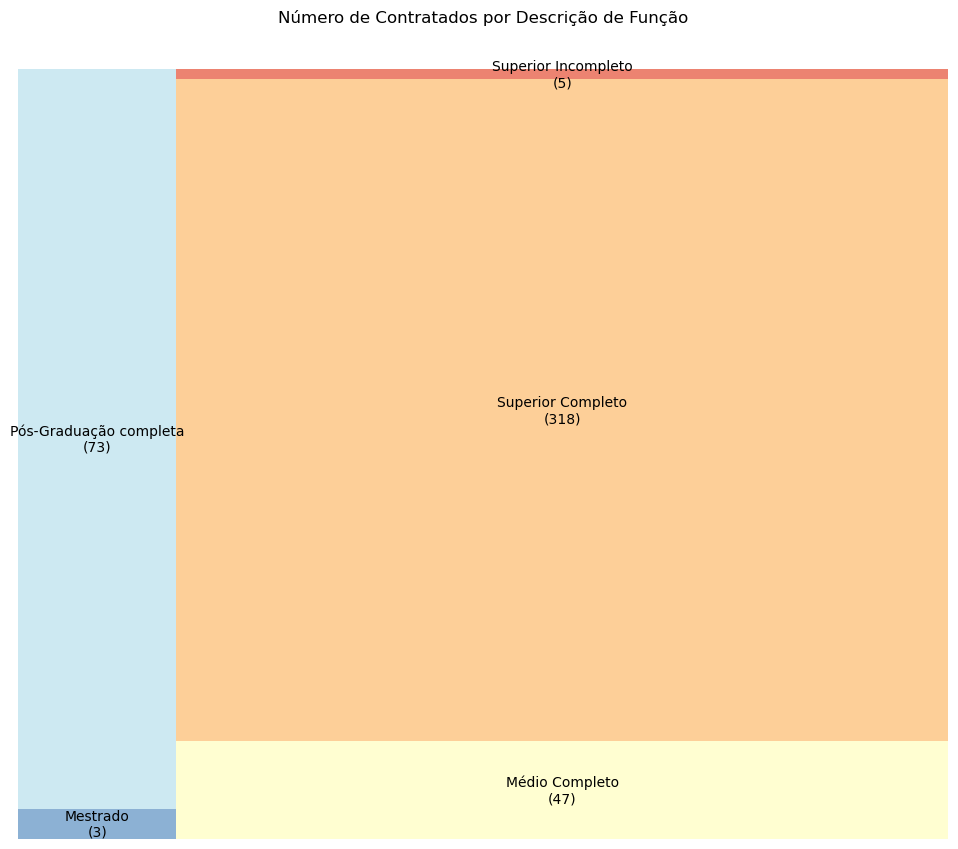

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import squarify

# Criando o dataframe
df_function = pd.DataFrame({
    'descricao': ['Mestrado', 'Pós-Graduação completa', 'Médio Completo', 'Superior Completo', 'Superior Incompleto'],
    'numero_contratados': [3, 73, 47, 318, 5]
})

# Definindo os dados para o treemap
labels = [f"{desc}\n({val})" for desc, val in zip(df_function['descricao'], df_function['numero_contratados'])]
values = df_function['numero_contratados']
colors = plt.cm.RdYlBu_r(np.linspace(0.15, 0.85, len(labels)))

# Criando o treemap
plt.figure(figsize=(12, 10))
squarify.plot(sizes=values, label=labels, color=colors, alpha=0.7, text_kwargs={'fontsize':10})
plt.title('Número de Contratados por Descrição de Função', y=1.05)  # Ajustando o espaço com o parâmetro y
plt.axis('off')  # Esconde os eixos
plt.savefig('./images/graphs/escolaridade.png')

plt.show()


